# LMSR Pricing Test: Understanding Price Dynamics

This notebook demonstrates **how and why** LMSR prices change based on trading activity.

In [5]:
%matplotlib inline

import sys
from pathlib import Path

notebook_dir = Path().absolute()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.prediction_market_sim.market import LMSRMarket

output_dir = project_root / 'pricing_test'
output_dir.mkdir(exist_ok=True)
print('✅ Setup complete')
print(f'📁 Working from: {project_root}')

✅ Setup complete
📁 Working from: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations


## 1. LMSR Pricing Formula

The LMSR (Logarithmic Market Scoring Rule) calculates prices based on **outstanding shares**:

$$Price_{YES} = \frac{e^{q_{YES}/b}}{e^{q_{YES}/b} + e^{q_{NO}/b}}$$

Where:
- $q_{YES}$ = cumulative YES shares purchased (positive = net buying, negative = net selling)
- $q_{NO}$ = cumulative NO shares purchased
- $b$ = liquidity parameter = 100.0 (higher = more liquidity = slower price movement)

### Key Insight:
- **Buy YES** → $q_{YES}$ increases → Price goes UP
- **Sell YES** → $q_{YES}$ decreases → Price goes DOWN
- The more you trade, the more the price moves (diminishing returns)

## 2. Run Trading Simulation

In [6]:
# Create market
market = LMSRMarket(liquidity_param=100.0, initial_shares={'YES': 0.0, 'NO': 0.0})
print(f'Initial Price: {market.get_price("YES"):.4f} (50.00%)\n')

# Define trade sequence
trade_pattern = [
    ('BUY', 10),   ('BUY', 15),  ('SELL', 5),
    ('BUY', 20),   ('SELL', 10), ('BUY', 10),
    ('BUY', 5),    ('SELL', 15), ('BUY', 25),
    ('SELL', 8)
]
trades = trade_pattern * 3  # Repeat 3 times = 30 trades

# Track detailed information
trade_log = []
timestep = 0
price_before = market.get_price('YES')
shares_yes = 0.0
shares_no = 0.0

# Initial state
trade_log.append({
    'timestep': timestep,
    'action': 'INITIAL',
    'quantity': 0,
    'price_before': price_before,
    'price_after': price_before,
    'price_change': 0.0,
    'shares_yes': shares_yes,
    'shares_no': shares_no,
    'cumulative_volume': 0
})

cumulative_volume = 0

# Execute trades and log each one
for i, (side, qty) in enumerate(trades, 1):
    price_before = market.get_price('YES')
    shares = qty if side == 'BUY' else -qty
    
    # Execute trade
    market.buy_shares(
        agent_id=f'agent_{i%5}',
        outcome='YES',
        num_shares=shares,
        timestamp=i
    )
    
    price_after = market.get_price('YES')
    shares_yes += shares
    cumulative_volume += qty
    
    trade_log.append({
        'timestep': i,
        'action': side,
        'quantity': qty,
        'price_before': price_before,
        'price_after': price_after,
        'price_change': price_after - price_before,
        'shares_yes': shares_yes,
        'shares_no': shares_no,
        'cumulative_volume': cumulative_volume
    })

df_trades = pd.DataFrame(trade_log)
print(f'✅ Executed {len(trades)} trades')
print(f'Final Price: {price_after:.4f} ({price_after*100:.2f}%)')
print(f'Total Price Change: {price_after - 0.5:+.4f} ({(price_after - 0.5)*100:+.2f}%)')

Initial Price: 0.5000 (50.00%)

✅ Executed 30 trades
Final Price: 0.8038 (80.38%)
Total Price Change: +0.3038 (+30.38%)


## 3. Trade-by-Trade Analysis

Let's see **exactly what happened** at each timestamp:

In [7]:
# Format the dataframe for display
df_display = df_trades.copy()
df_display['price_before_%'] = (df_display['price_before'] * 100).round(2)
df_display['price_after_%'] = (df_display['price_after'] * 100).round(2)
df_display['price_change_%'] = (df_display['price_change'] * 100).round(2)
df_display['shares_yes'] = df_display['shares_yes'].round(2)

# Show first 15 trades
print('First 15 Trades:')
df_display[['timestep', 'action', 'quantity', 'price_before_%', 'price_after_%', 'price_change_%', 'shares_yes']].head(15)

First 15 Trades:


,timestep,action,quantity,price_before_%,price_after_%,price_change_%,shares_yes
0,0,INITIAL,0,50.00,50.00,0.00,0.0
1,1,BUY,10,50.00,52.50,2.50,10.0
2,2,BUY,15,52.50,56.22,3.72,25.0
3,3,SELL,5,56.22,54.98,-1.23,20.0
4,4,BUY,20,54.98,59.87,4.89,40.0
5,5,SELL,10,59.87,57.44,-2.42,30.0
6,6,BUY,10,57.44,59.87,2.42,40.0
7,7,BUY,5,59.87,61.06,1.20,45.0
8,8,SELL,15,61.06,57.44,-3.62,30.0
9,9,BUY,25,57.44,63.41,5.97,55.0


## 4. Key Observations

Notice how:
- **BUY orders** → Price increases (positive price_change)
- **SELL orders** → Price decreases (negative price_change)
- **Larger orders** → Bigger price impact
- **Price change slows** as we move away from 50% (liquidity parameter effect)

In [8]:
# Summary statistics
buys = df_trades[df_trades['action'] == 'BUY']
sells = df_trades[df_trades['action'] == 'SELL']

print('='*60)
print('TRADING SUMMARY')
print('='*60)
print(f'Total Trades:        {len(trades)}')
print(f'Buy Orders:          {len(buys)} ({len(buys)/len(trades)*100:.1f}%)')
print(f'Sell Orders:         {len(sells)} ({len(sells)/len(trades)*100:.1f}%)')
print(f'\nTotal Buy Volume:    {buys["quantity"].sum():.0f} shares')
print(f'Total Sell Volume:   {sells["quantity"].sum():.0f} shares')
print(f'Net Volume:          {buys["quantity"].sum() - sells["quantity"].sum():+.0f} shares (BUY pressure)')
print(f'\nAvg Price Impact:')
print(f'  Per BUY order:     {buys["price_change"].mean():+.4f} ({buys["price_change"].mean()*100:+.2f}%)')
print(f'  Per SELL order:    {sells["price_change"].mean():+.4f} ({sells["price_change"].mean()*100:+.2f}%)')
print(f'\nFinal Outstanding Shares:')
print(f'  YES:               {df_trades["shares_yes"].iloc[-1]:.2f}')
print(f'  NO:                {df_trades["shares_no"].iloc[-1]:.2f}')
print('='*60)

TRADING SUMMARY
Total Trades:        30
Buy Orders:          18 (60.0%)
Sell Orders:         12 (40.0%)

Total Buy Volume:    255 shares
Total Sell Volume:   114 shares
Net Volume:          +141 shares (BUY pressure)

Avg Price Impact:
  Per BUY order:     +0.0299 (+2.99%)
  Per SELL order:    -0.0195 (-1.95%)

Final Outstanding Shares:
  YES:               141.00
  NO:                0.00


## 5. Visualize Price Evolution with Trade Context

✅ Saved detailed plot


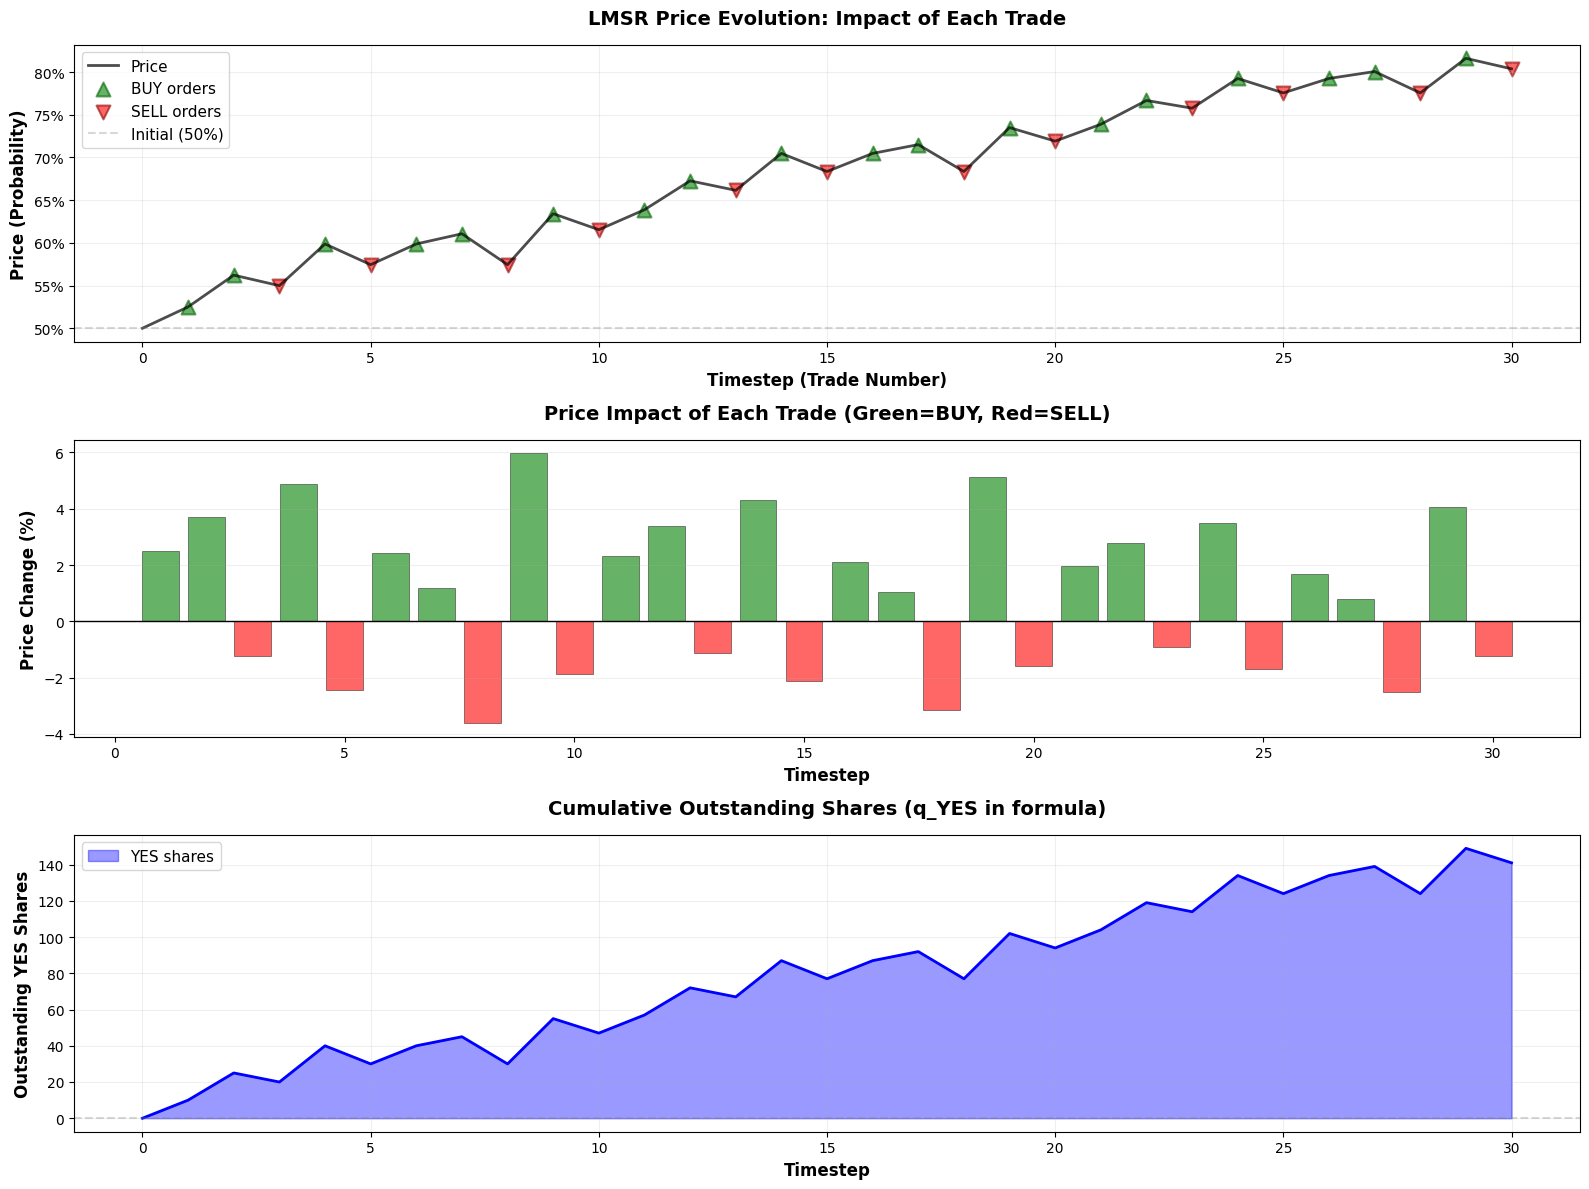

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# --- PLOT 1: Price Evolution with Buy/Sell Markers ---
ax1 = axes[0]
ax1.plot(df_trades['timestep'], df_trades['price_after'], 'k-', linewidth=2, label='Price', alpha=0.7)

# Mark BUY orders
buys = df_trades[df_trades['action'] == 'BUY']
ax1.scatter(buys['timestep'], buys['price_after'], color='green', s=100, marker='^', 
            label='BUY orders', alpha=0.6, edgecolors='darkgreen', linewidth=1.5)

# Mark SELL orders
sells = df_trades[df_trades['action'] == 'SELL']
ax1.scatter(sells['timestep'], sells['price_after'], color='red', s=100, marker='v',
            label='SELL orders', alpha=0.6, edgecolors='darkred', linewidth=1.5)

ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.3, label='Initial (50%)')
ax1.set_xlabel('Timestep (Trade Number)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (Probability)', fontsize=12, fontweight='bold')
ax1.set_title('LMSR Price Evolution: Impact of Each Trade', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.2)
ax1.legend(loc='upper left', fontsize=11)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# --- PLOT 2: Price Change per Trade ---
ax2 = axes[1]
colors = ['green' if action == 'BUY' else 'red' for action in df_trades['action'][1:]]
ax2.bar(df_trades['timestep'][1:], df_trades['price_change'][1:]*100, color=colors, alpha=0.6, edgecolor='black', linewidth=0.5)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Timestep', fontsize=12, fontweight='bold')
ax2.set_ylabel('Price Change (%)', fontsize=12, fontweight='bold')
ax2.set_title('Price Impact of Each Trade (Green=BUY, Red=SELL)', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.2, axis='y')

# --- PLOT 3: Cumulative Outstanding Shares ---
ax3 = axes[2]
ax3.fill_between(df_trades['timestep'], 0, df_trades['shares_yes'], alpha=0.4, color='blue', label='YES shares')
ax3.plot(df_trades['timestep'], df_trades['shares_yes'], 'b-', linewidth=2)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax3.set_xlabel('Timestep', fontsize=12, fontweight='bold')
ax3.set_ylabel('Outstanding YES Shares', fontsize=12, fontweight='bold')
ax3.set_title('Cumulative Outstanding Shares (q_YES in formula)', fontsize=14, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.2)
ax3.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig(output_dir / 'price_evolution_detailed.png', dpi=150, bbox_inches='tight')
print('✅ Saved detailed plot')
plt.show()

## 6. Why Did the Price Move This Way?

Let's analyze specific timesteps:

In [10]:
# Find biggest price movements
top_increases = df_trades.nlargest(5, 'price_change')[['timestep', 'action', 'quantity', 'price_before', 'price_after', 'price_change']]
top_decreases = df_trades.nsmallest(5, 'price_change')[['timestep', 'action', 'quantity', 'price_before', 'price_after', 'price_change']]

print('TOP 5 PRICE INCREASES:')
print(top_increases.to_string(index=False))
print('\nTOP 5 PRICE DECREASES:')
print(top_decreases.to_string(index=False))

TOP 5 PRICE INCREASES:
 timestep action  quantity  price_before  price_after  price_change
        9    BUY        25      0.574443     0.634136      0.059693
       19    BUY        25      0.683521     0.734973      0.051452
        4    BUY        20      0.549834     0.598688      0.048854
       14    BUY        20      0.661503     0.704746      0.043243
       29    BUY        25      0.775564     0.816078      0.040514

TOP 5 PRICE DECREASES:
 timestep action  quantity  price_before  price_after  price_change
        8   SELL        15      0.610639     0.574443     -0.036197
       18   SELL        15      0.715042     0.683521     -0.031521
       28   SELL        15      0.800592     0.775564     -0.025028
        5   SELL        10      0.598688     0.574443     -0.024245
       15   SELL        10      0.704746     0.683521     -0.021225


## 7. Compare to Order Book (Kalshi)

| Feature | LMSR (Our Implementation) | Order Book (Kalshi) |
|---------|---------------------------|---------------------|
| **Pricing** | Formula: $Price = f(q_{YES}, q_{NO})$ | Last matched trade price |
| **Order Execution** | ✅ **Always instant** at calculated price | ❌ Only if counterparty exists |
| **Price Discovery** | Automatic via formula | Market-driven matching |
| **Liquidity** | ✅ **Always available** (market maker) | ❌ Depends on order book depth |
| **Spread** | ✅ **Zero spread** | ❌ Bid-ask spread exists |
| **Slippage** | Predictable (larger orders = bigger impact) | Unpredictable (depends on book) |
| **Transparency** | ✅ Can calculate price impact before trading | ❌ Must check order book |

### Example: Star Player Gets Injured

**LMSR (Our Market):**
```
t=0: Price = 65% (Team favored to win)
📰 NEWS: Star QB injured!
Agent beliefs update: 65% → 35%

t=1: Agent submits SELL 50 shares
     → INSTANT execution at 62%
     → Price drops to 58%
     ✅ Trade guaranteed

t=2: More agents see news, sell more
     → Price continues dropping to 40%
     → Market reflects new consensus
```

**Order Book (Kalshi):**
```
t=0: Best Bid=64%, Best Ask=66%
📰 NEWS: Star QB injured!

t=1: Agent submits SELL at 60%
     → Waits for buyer...
     → No match (buyers want lower price)
     ❌ Trade stuck

t=2: Agent lowers to 55%
     → Still waiting...
     → Maybe executes if lucky
     ❌ Execution uncertain
```

## 8. Save Results

In [11]:
# Save detailed trade log
df_trades.to_csv(output_dir / 'trade_log.csv', index=False)
print(f'✅ Saved: {output_dir / "trade_log.csv"}')

# Save summary
summary = {
    'Initial Price': f"{df_trades['price_after'].iloc[0]:.4f}",
    'Final Price': f"{df_trades['price_after'].iloc[-1]:.4f}",
    'Total Change': f"{df_trades['price_after'].iloc[-1] - df_trades['price_after'].iloc[0]:+.4f}",
    'Total Trades': len(trades),
    'Buy Orders': len(buys),
    'Sell Orders': len(sells),
    'Final YES Shares': f"{df_trades['shares_yes'].iloc[-1]:.2f}"
}

import json
with open(output_dir / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f'✅ Saved: {output_dir / "summary.json"}')
print('\n' + '='*60)
print('✅ ANALYSIS COMPLETE!')
print('='*60)
print(f'\nFiles saved in: {output_dir}/')
print('  • trade_log.csv - Full trade-by-trade data')
print('  • price_evolution_detailed.png - Multi-panel visualization')
print('  • summary.json - Key metrics')

✅ Saved: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations/pricing_test/trade_log.csv
✅ Saved: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations/pricing_test/summary.json

✅ ANALYSIS COMPLETE!

Files saved in: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations/pricing_test/
  • trade_log.csv - Full trade-by-trade data
  • price_evolution_detailed.png - Multi-panel visualization
  • summary.json - Key metrics
